In [81]:
import os 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime

%matplotlib inline

In [82]:
os.chdir('../src/')
print(os.getcwd())

C:\Users\joh3146\Documents\dssg\air_pollution_estimation\src


In [83]:
from traffic_analysis.d00_utils.load_confs import load_parameters, load_credentials, load_paths
from traffic_analysis.d00_utils.data_loader_sql import DataLoaderSQL
from traffic_analysis.d05_evaluation.chunk_evaluator import ChunkEvaluator
# from traffic_viz.d06_visualisation.chunk_evaluation_plotting import (
#     plot_video_stats_diff_distribution,
#     plot_video_level_summary_stats,
#     plot_mAP_over_time)

params = load_parameters()
creds = load_credentials()
paths = load_paths()
pd.set_option('display.max_columns', 500)

To read in evaluation results table from sql, need to be on the ec2... otherwise can download locally as a csv and then uploaded.

In [84]:
video_performance_df = pd.read_csv("../data/eval/eval_video_performance_gpu.csv")
video_accuracy_df = pd.read_csv("../data/eval/eval_video_diffs_gpu.csv")
frame_accuracy_df = pd.read_csv("../data/eval/eval_frame_stats_gpu.csv")

FileNotFoundError: [Errno 2] File b'../data/eval/eval_video_performance_gpu.csv' does not exist: b'../data/eval/eval_video_performance_gpu.csv'

In [5]:
video_accuracy_df.stop_start_iou_threshold.unique()

array([0.75, 0.8 , 0.85, 0.9 ])

In [6]:
video_accuracy_df.detection_model.unique()

array(['yolov3_opencv', 'yolov3_tf', 'traffic_tf'], dtype=object)

Merge the different grid search params into one column, divided by underscores and then convert to a lettering or other naming convention

In [7]:
columns_to_join = ['tracker_type', 'detection_model', 'detection_frequency', 
                   'detection_iou_threshold', 'stop_start_iou_threshold']

video_performance_df['model_search'] = video_performance_df[columns_to_join].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)

video_accuracy_df['model_search'] = video_accuracy_df[columns_to_join].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)

frame_accuracy_df['model_search'] = frame_accuracy_df[columns_to_join].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)

video_performance_df['model_search'].head()

0    kcf,yolov3_opencv,4,0.2,0.75
1    kcf,yolov3_opencv,4,0.2,0.75
2    kcf,yolov3_opencv,4,0.2,0.75
3    kcf,yolov3_opencv,4,0.2,0.75
4    kcf,yolov3_opencv,4,0.2,0.75
Name: model_search, dtype: object

In [8]:
video_performance_df.model_search.nunique()

430

Remove the data that contains the opencv implementations

In [9]:
eval_dfs = [video_performance_df, video_accuracy_df, frame_accuracy_df]

for eval_df in eval_dfs:
    opencv_idx = eval_df[eval_df.detection_model == 'yolov3_opencv'].index
    eval_df.drop(opencv_idx, inplace=True)
    
eval_dfs[0].detection_model.unique()

array(['yolov3_tf', 'traffic_tf'], dtype=object)

See if the number of cameras evaluated among model implementations is consistent 

In [10]:
video_performance_df.columns
video_performance_df.n_videos.unique()

array([50, 47, 43, 42, 46, 61, 63, 51, 53, 48, 56, 58], dtype=int64)

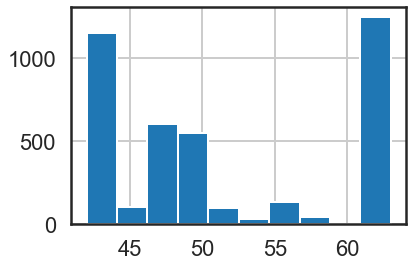

In [11]:
video_performance_df.n_videos.hist()

In [12]:
video_accuracy_df['camera_id'] = video_accuracy_df['camera_id'].astype(str)
video_accuracy_df['video_id'] = video_accuracy_df.camera_id + '_' + video_accuracy_df.video_upload_datetime
video_accuracy_df.video_id.nunique()

65

Since it's inconsistent in total number of videos analyzed, need to see if the 42 videos in the min is at least consistent among all videos.

In [14]:
video_performance_df.columns
video_performance_df.model_search[video_performance_df.n_videos == 42].unique()
video_performance_df.detection_iou_threshold[video_performance_df.n_videos == 42].unique()

array([0.5])

In [15]:
models_with_min_num_vids = video_performance_df.model_search[video_performance_df.n_videos == 42].unique()
vids_in_min_num_vids = [video_accuracy_df.video_id[
    video_accuracy_df.model_search == model].values for model in models_with_min_num_vids]

video_accuracy_filtered_df = video_accuracy_df[video_accuracy_df.video_id.isin(vids_in_min_num_vids[0])]
n_vid = video_accuracy_filtered_df.video_id.nunique()
n_vid

42

the 42 videos are at least consistent. yay.

In [16]:
frame_accuracy_df['camera_id'] = frame_accuracy_df['camera_id'].astype(str)
frame_accuracy_df['video_id'] = frame_accuracy_df.camera_id + '_' + frame_accuracy_df.video_upload_datetime

vids_in_min_num_vids = [frame_accuracy_df.video_id[
    frame_accuracy_df.model_search == model].values for model in models_with_min_num_vids]

frame_accuracy_filtered_df = frame_accuracy_df[frame_accuracy_df.video_id.isin(vids_in_min_num_vids[0])]
frame_accuracy_filtered_df.video_id.nunique()

38

not sure why frame_accuracy_filtered has 38 videos = different?

In [17]:
counts_diff_df = video_accuracy_filtered_df.groupby(['vehicle_type', 'model_search', 'video_id']).counts_diff.agg(sum).reset_index()
counts_diff_df.head()

,vehicle_type,model_search,video_id,counts_diff
0,bus,"boosting,traffic_tf,4,0.2,0.75",1.01252_2019-06-20 05:58:17,0
1,bus,"boosting,traffic_tf,4,0.2,0.75",1.01252_2019-06-27 03:01:57,0
2,bus,"boosting,traffic_tf,4,0.2,0.75",1.01252_2019-07-01 03:01:37,0
3,bus,"boosting,traffic_tf,4,0.2,0.75",1.01252_2019-07-02 02:58:08,1
4,bus,"boosting,traffic_tf,4,0.2,0.75",1.0349_2019-06-29 13:00:56,-1


In [18]:
counts_diff_df['abs_counts_diff'] = counts_diff_df.counts_diff.apply(lambda x: abs(x))
counts_diff_df.head()

,vehicle_type,model_search,video_id,counts_diff,abs_counts_diff
0,bus,"boosting,traffic_tf,4,0.2,0.75",1.01252_2019-06-20 05:58:17,0,0
1,bus,"boosting,traffic_tf,4,0.2,0.75",1.01252_2019-06-27 03:01:57,0,0
2,bus,"boosting,traffic_tf,4,0.2,0.75",1.01252_2019-07-01 03:01:37,0,0
3,bus,"boosting,traffic_tf,4,0.2,0.75",1.01252_2019-07-02 02:58:08,1,1
4,bus,"boosting,traffic_tf,4,0.2,0.75",1.0349_2019-06-29 13:00:56,-1,1


In [19]:
vid_level_model_comparison_df = counts_diff_df.groupby(
    ['model_search', 'video_id'])['counts_diff', 'abs_counts_diff'].agg(sum).reset_index()
vid_level_model_comparison_df.columns

Index(['model_search', 'video_id', 'counts_diff', 'abs_counts_diff'], dtype='object')

In [20]:
vid_level_model_comparison_df.rename(columns={'abs_counts_diff' : 'abs_counts_diff_by_veh_type'}, inplace=True)
vid_level_model_comparison_df['abs_counts_diff_on_vid_level'] = vid_level_model_comparison_df.counts_diff.apply(
    lambda x: abs(x))

model_comparison_df = vid_level_model_comparison_df.groupby(
    ['model_search'])['abs_counts_diff_on_vid_level', 'abs_counts_diff_by_veh_type'].agg(sum).reset_index()

In [21]:
model_comparison_df.abs_counts_diff_on_vid_level = model_comparison_df.abs_counts_diff_on_vid_level / n_vid
model_comparison_df.abs_counts_diff_by_veh_type = model_comparison_df.abs_counts_diff_by_veh_type / n_vid
model_comparison_df.rename(columns={
    'abs_counts_diff_on_vid_level' : 'bias', 'abs_counts_diff_by_veh_type' : 'mae'}, inplace=True)
model_comparison_df.head()

,model_search,bias,mae
0,"boosting,traffic_tf,4,0.2,0.75",3.690476,4.404762
1,"boosting,traffic_tf,4,0.2,0.8",3.690476,4.404762
2,"boosting,traffic_tf,4,0.2,0.85",3.690476,4.404762
3,"boosting,traffic_tf,4,0.2,0.9",3.690476,4.404762
4,"boosting,traffic_tf,4,0.3,0.75",3.047619,3.619048


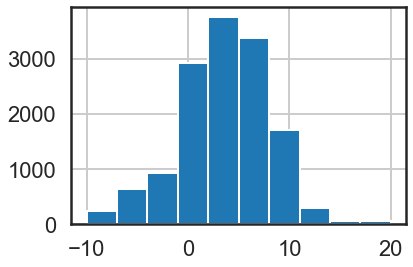

In [22]:
counts_diff_df[counts_diff_df.vehicle_type == 'car'].counts_diff.hist()

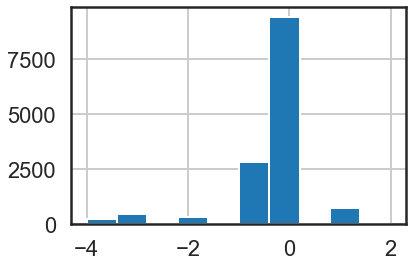

In [23]:
counts_diff_df[counts_diff_df.vehicle_type == 'bus'].counts_diff.hist()

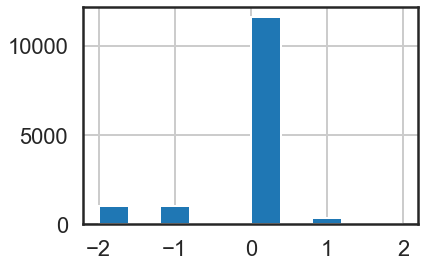

In [24]:
counts_diff_df[counts_diff_df.vehicle_type == 'truck'].counts_diff.hist()

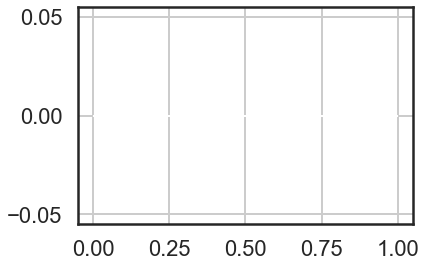

In [25]:
counts_diff_df[counts_diff_df.vehicle_type == 'motorcycle'].counts_diff.hist()

seems like we're always overpredicting cars but slightly underpredicting trucks and buses.

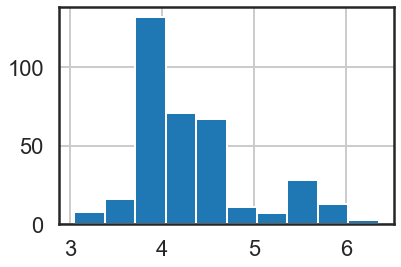

In [26]:
model_comparison_df.bias.hist()

In [27]:
speed_df = video_performance_df.groupby(['model_search']).avg_analyser_runtime.mean().reset_index()
model_comparison_df = model_comparison_df.merge(speed_df, on = 'model_search')
model_comparison_df.head()

,model_search,bias,mae,avg_analyser_runtime
0,"boosting,traffic_tf,4,0.2,0.75",3.690476,4.404762,8.146978
1,"boosting,traffic_tf,4,0.2,0.8",3.690476,4.404762,8.149952
2,"boosting,traffic_tf,4,0.2,0.85",3.690476,4.404762,8.033343
3,"boosting,traffic_tf,4,0.2,0.9",3.690476,4.404762,7.784351
4,"boosting,traffic_tf,4,0.3,0.75",3.047619,3.619048,7.498267


what is the fastest and the most accurate model? are they the same?

In [28]:
accurate_model_idx = model_comparison_df.mae.idxmin()
accurate_model = model_comparison_df.model_search[accurate_model_idx]

fastest_model_idx = model_comparison_df[model_comparison_df.avg_analyser_runtime < 1].mae.idxmin()
fastest_model = model_comparison_df.model_search[fastest_model_idx]

best_model_idx = model_comparison_df[model_comparison_df.avg_analyser_runtime < 1].mae.idxmin()
best_model = model_comparison_df.model_search[best_model_idx]

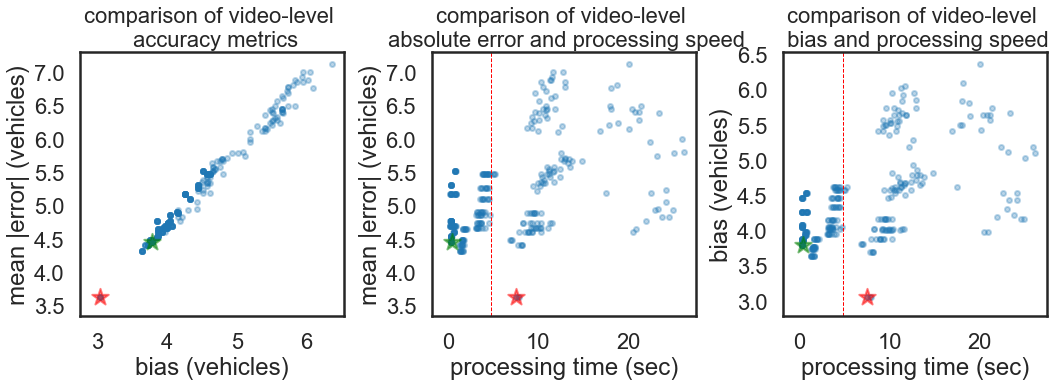

In [29]:
fig, ax = plt.subplots(1,3, figsize=(15, 5))
plt.tight_layout()


SMALL_SIZE=16
MEDIUM_SIZE=22
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

ax[0].scatter(model_comparison_df.bias,
              model_comparison_df.mae,
              s=25, alpha=0.3, label='model_ensemble'
             )

ax[0].scatter(model_comparison_df.bias[best_model_idx],
            model_comparison_df.mae[best_model_idx],
            label='lowest error model above speed threshold', s=300, alpha=0.5, color='green', marker='*'
           )

ax[0].scatter(model_comparison_df.bias[accurate_model_idx],
            model_comparison_df.mae[accurate_model_idx],
            label='lowest error model', color='red', s=300, alpha=0.5, marker='*'
           )


ax[0].set_xlabel('bias (vehicles)')
ax[0].set_ylabel('mean |error| (vehicles)')
ax[0].set_title('comparison of video-level \n accuracy metrics');


ax[1].scatter(model_comparison_df.avg_analyser_runtime,
            model_comparison_df.mae,
            label='model ensemble', s=25, alpha=0.3
           )

ax[1].scatter(model_comparison_df.avg_analyser_runtime[best_model_idx],
            model_comparison_df.mae[best_model_idx],
            label='lowest error model above speed threshold', color='green', s=300, alpha=0.5, marker='*'
           )

ax[1].scatter(model_comparison_df.avg_analyser_runtime[accurate_model_idx],
            model_comparison_df.mae[accurate_model_idx],
            label='lowest error model', color='red', s=300, alpha=0.5, marker='*'
           )

ax[1].set_xlabel('processing time (sec)')
ax[1].set_ylabel('mean |error| (vehicles)')
ax[1].set_title('comparison of video-level \n absolute error and processing speed')
ax[1].axvline(4.8, color='red', label='speed threshold', lw=1, ls='--')


ax[2].scatter(model_comparison_df.avg_analyser_runtime,
            model_comparison_df.bias,
            label='model ensemble', s=25, alpha=0.3
           )

ax[2].scatter(model_comparison_df.avg_analyser_runtime[best_model_idx],
            model_comparison_df.bias[best_model_idx],
            label='lowest error model above speed threshold', color='green', s=300, alpha=0.5, marker='*'
           )

ax[2].scatter(model_comparison_df.avg_analyser_runtime[accurate_model_idx],
            model_comparison_df.bias[accurate_model_idx],
            label='lowest error model', color='red', s=300, alpha=0.5, marker='*'
           )

ax[2].set_xlabel('processing time (sec)')
ax[2].set_ylabel('bias (vehicles)')
ax[2].set_title('comparison of video-level \n bias and processing speed')
ax[2].axvline(4.8, color='red', label='speed threshold', lw=1, ls='--')

# ax[2].legend();

Text(12.25, 0.5, 'bias (vehicles)')

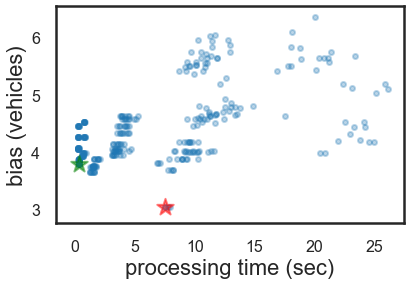

In [36]:
fig, ax = plt.subplots()
plt.tight_layout()

ax.scatter(model_comparison_df.avg_analyser_runtime,
            model_comparison_df.bias,
            label='model ensemble', s=25, alpha=0.3
           )

ax.scatter(model_comparison_df.avg_analyser_runtime[best_model_idx],
            model_comparison_df.bias[best_model_idx],
            label='lowest error model above speed threshold', color='green', s=300, alpha=0.5, marker='*'
           )

ax.scatter(model_comparison_df.avg_analyser_runtime[accurate_model_idx],
            model_comparison_df.bias[accurate_model_idx],
            label='lowest error model', color='red', s=300, alpha=0.5, marker='*'
           )

ax.set_xlabel('processing time (sec)')
ax.set_ylabel('bias (vehicles)')

In [30]:
model_comparison_df.model_search.nunique()

331

In [31]:
model_comparison_df.iloc[best_model_idx]

model_search            mosse,traffic_tf,4,0.5,0.75
bias                                        3.78571
mae                                         4.45238
avg_analyser_runtime                       0.362597
Name: 215, dtype: object

In [32]:
model_comparison_df.iloc[accurate_model_idx]

model_search            boosting,traffic_tf,4,0.3,0.75
bias                                           3.04762
mae                                            3.61905
avg_analyser_runtime                           7.49827
Name: 4, dtype: object

In [33]:
model_comparison_df.iloc[fastest_model_idx]

model_search            mosse,traffic_tf,4,0.5,0.75
bias                                        3.78571
mae                                         4.45238
avg_analyser_runtime                       0.362597
Name: 215, dtype: object

In [44]:
vid_level_model_comparison_df.columns

Index(['model_search', 'video_id', 'counts_diff',
       'abs_counts_diff_by_veh_type', 'abs_counts_diff_on_vid_level'],
      dtype='object')

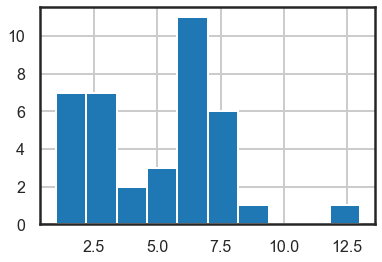

In [45]:
vid_level_model_comparison_df[vid_level_model_comparison_df.model_search == fastest_model].abs_counts_diff_by_veh_type.hist()

In [75]:
vid_level_best_model_df = video_accuracy_df[video_accuracy_df.model_search == fastest_model]
vid_level_best_model_df.stops_pred = vid_level_best_model_df.stops_pred.apply(lambda x: abs(x))
vid_level_best_model_df = vid_level_best_model_df.drop(['video_id', 'model_search','creation_datetime','count_true', 'starts_true', 'stops_true', 'counts_diff', 'starts_diff', 'stops_diff'], axis=1)

C:\Users\joh3146\AppData\Local\Continuum\anaconda3\envs\dssg\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [76]:
vid_level_best_model_df.columns

Index(['camera_id', 'video_upload_datetime', 'vehicle_type', 'counts_pred',
       'starts_pred', 'stops_pred', 'tracker_type', 'detection_model',
       'detection_frequency', 'detection_iou_threshold',
       'stop_start_iou_threshold'],
      dtype='object')

In [77]:
vid_level_best_model_df.to_csv(path_or_buf='C:/Users/joh3146/Desktop/example_traffic_data.csv',
                               sep=',',
                               index=False)

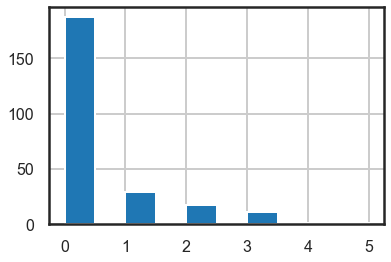

In [78]:
vid_level_best_model_df.stops_pred.hist()